In [1]:
import morphs
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
import scipy as sp

/usr/local/anaconda/envs/morphs/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
accuracies, cluster_accuracies = morphs.data.load.cluster_accuracies()
good_recs = morphs.data.accuracies.good_recs(cluster_accuracies)

In [3]:
# try to find nice block used below, else use last one found
for block_path in morphs.paths.blocks():
    if 'Pen01_Lft_AP2500_ML750__Site04_Z2300__B1101_cat_P01_S04_3' in block_path:
        break
subj = morphs.data.parse.bird_id(block_path)
good_clusters = morphs.data.accuracies.good_clusters(cluster_accuracies[block_path])

In [4]:
spikes = morphs.data.load.ephys_data(block_path, good_clusters=good_clusters, shuffle_endpoints=True)

/usr/local/anaconda/envs/morphs/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/anaconda/envs/morphs/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
X, labels = morphs.spikes.create_neural_rep(spikes, max_id_len=5)
X_red = morphs.data.neurometric.logistic_dim_reduction(X, labels)
psychometric_params = morphs.data.load.psychometric_params()

In [6]:
behavior_subj = 'B1218'

In [7]:
sns.set_context("talk")

In [8]:
def _cf_4pl(x, A, K, B, M):
    return A + (K - A) / (1 + np.exp(-B * (x - M)))

def _4pl(x, y, color=None, **kwargs):
    data = kwargs.pop("data")

    popt, pcov = sp.optimize.curve_fit(_cf_4pl, data[x].values, data[y].values)
    try:
        result_4pl = morphs.logistic.four_param_logistic(popt)
        t = np.arange(128) + 1
        
        if color is None:
            lines, = plt.plot(x.mean(), y.mean())
            color = lines.get_color()
            lines.remove()
        
        plt.plot(t, result_4pl(t), color=color)
    except TypeError:
        pass

def held_out(labels, representations, behavior_subj, psychometric_params, **kwargs):
    label_df = morphs.data.neurometric.make_label_df(labels, behavior_subj, psychometric_params)
    behavior_df = morphs.data.neurometric.make_behavior_df(behavior_subj, psychometric_params)
    merged_df = morphs.data.neurometric._merge_df(label_df, behavior_df)
    held_out_df = morphs.data.neurometric.gen_held_out_df(merged_df, representations, melt=True)
    g = grid(held_out_df, **kwargs)
    return held_out_df, g

def grid(held_out_df, sup_title='', 
         legend=True, legend_title='',
         p_right_leg_label='Behavioral (True) values',
         predicted_leg_label='Predicted values',
         sub_title="{row_name}                  {col_name}"):
    held_out_df['legend'] = held_out_df['legend'].map({'p_right':p_right_leg_label, 'predicted':predicted_leg_label})
    row_order = np.sort(held_out_df['lesser_dim'].unique())
    col_order = np.sort(held_out_df['greater_dim'].unique())
    g = sns.lmplot(x='morph_pos', y='p_right', hue='legend', col='greater_dim', row='lesser_dim', 
                   data=held_out_df, 
                   scatter=True, fit_reg=False,
                   scatter_kws={'alpha': 0.3},
                   row_order=row_order, col_order=col_order, legend=False)
    g.map_dataframe(_4pl, 'morph_pos', 'p_right')
    if legend:
        g.add_legend(title=legend_title)
    g = g.set_titles(sub_title)
    g.set(xlim=(0, 128), ylim=(0, 1), xticks=[], yticks=[0.0, 0.5, 1.0]);
    g.set_axis_labels("morph position", "P(right response)");
    
    if sup_title:
        plt.subplots_adjust(top=0.95)
        g.fig.suptitle(sup_title)
    return g

/usr/local/anaconda/envs/morphs/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


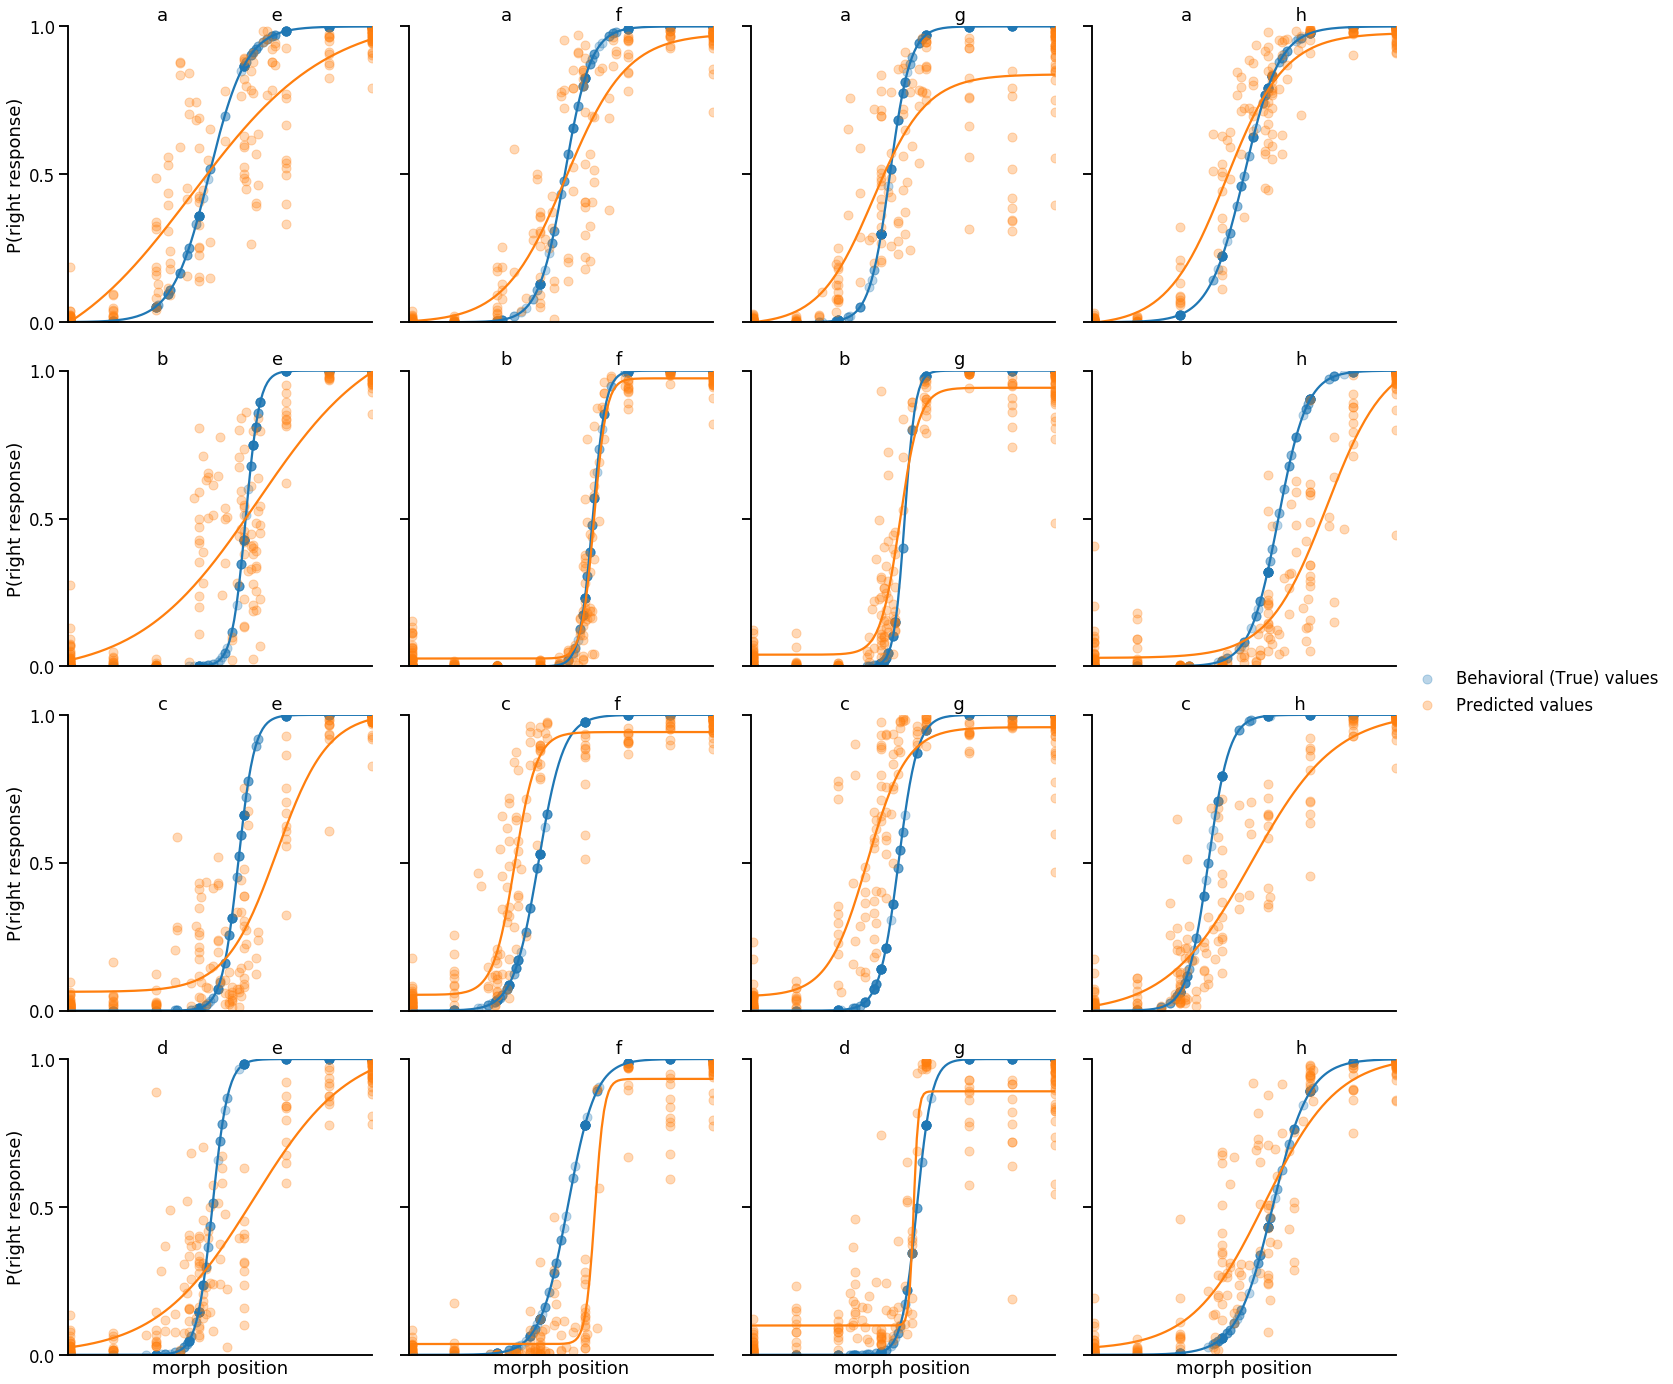

In [9]:
held_out_df, g = held_out(labels, X_red, behavior_subj, psychometric_params)